In [45]:
import numpy as np
import xtrack as xt
import xobjects as xo
import xpart as xp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import constants 


line = xt.Line.from_json('sps.json')
particle_ref=line.particle_ref

line.build_tracker()
#line.freeze_longitudinal()
# line.optimize_for_tracking()

twiss=line.twiss()

#%%
###################
# Linear Transfer #
###################

qx=twiss['qx']
qy=twiss['qy']
dqx=twiss['dqx']
dqy=twiss['dqy']
circumference=twiss['s'][-1]
# beta_x=twiss['betx'][-1]
# beta_y=twiss['bety'][-1]

qs=twiss['qs']
bets=twiss['betz0']


#at interaction points: #from https://anaconda.org/petrenko/li_like_ca_in_sps/notebook
beta_x  =  54.614389 # m
beta_y  =  44.332517 # m
alpha_x = -1.535235
alpha_y =  1.314101



Dx  =  2.444732 # m
Dpx =  0.097522


Dy  =  0.0 # m
Dpy =  0.0

#index of gamma factory along SPS line: 16675

arc = xt.LineSegmentMap(
        qx=qx, qy=qy,
        dqx=0, dqy=0,
        length=circumference,
        alfx=alpha_x,
        alfy=alpha_y,
        betx=beta_x,
        bety=beta_y,
        
        dx=Dx,
        dpx=Dpx,
        dy=Dy,
        dpy=Dpy,
        qs=qs,
        bets=bets,
        )


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [46]:
clight=constants.speed_of_light
circumference = line.get_length()

class Ion:
    def __init__(self, name, A, Z, q0, excited_lifetime, hw0):
        m_u = 931.49410242e6  # eV/c^2 -- atomic mass unit
        m_e = 0.511e6  # eV/c^2 -- electron mass
        m_p = 938.272088e6  # eV/c^2 -- proton mass

        self.name = name
        self.A = A
        self.Z = Z
        self.q0 = q0  # e
        self.excited_lifetime = excited_lifetime  # s
        self.hw0 = hw0  # eV

        self.ne = Z - q0
        self.mass0 = self.A * m_u + self.ne * m_e  # eV/c^2

        N_pb = int(1.9 * 1e8)  # ion-bunch intensity for lead
        self.N_a = int(N_pb * (self.Z / 82) ** -1.9)  # ion-bunch intensity for arbitrary ion with charge Z
        self.Intensity = self.N_a


calcium = Ion(name="calcium", A=40, Z=20, q0=17, excited_lifetime=0.4279 * 1e-12, hw0=661.89)
xenon = Ion(name="xenon", A=129, Z=54, q0=39, excited_lifetime=3 * 1e-12, hw0=492.22)
lead = Ion(name="lead", A=208, Z=82, q0=79, excited_lifetime=76.6e-12, hw0=230.823)



ion=xenon

In [47]:
# Ion properties:
q0 = ion.q0
mass0 = ion.mass0

gamma = particle_ref.gamma0
beta= particle_ref.beta0
p0c = mass0*gamma*beta #eV/c

bunch_intensity = ion.Intensity

particle_ref = xp.Particles(p0c=p0c, mass0=mass0, q0=q0)

line.particle_ref=particle_ref


In [48]:
# # Source: https://www.sciencedirect.com/science/article/pii/S0146641020300399
# # Ion beam dimensions:
# sigma_x = 1.047e-3 # m
# sigma_y = 0.83e-3  # m
# sigma_z = 0.063 # m
# sigma_dp = 2e-4 # relative ion momentum spread

# sigma_px=4.36*1e-3 #calculated from the Twiss parameters
# sigma_py=4.36*1e-3 #calculated from the Twiss parameters

# num_particles = int(1e3)

# particles0 = xp.Particles(
#      mass0 = mass0, # eV/c^2
#      q0    = q0,
#      p0c   = p0c, # eV
#      x     = np.random.normal(scale=sigma_x, size=num_particles),
#      px    = np.random.normal(scale=sigma_px, size=num_particles),
#      y     = np.random.normal(scale=sigma_y, size=num_particles),
#      py    = np.random.normal(scale=sigma_py, size=num_particles),
#      zeta  = np.random.normal(scale=sigma_z, size=num_particles),
#      delta = np.random.normal(scale=sigma_dp, size=num_particles)
#         )

In [49]:
nemitt = 1.5e-6 # m*rad (normalized emittance)
sigma_z = 0.063 # m

emittance=nemitt/(beta*gamma)

num_particles=int(1e3)

line_arc=xt.Line(
        elements=[arc])
line_arc.build_tracker()

particles = xp.generate_matched_gaussian_bunch(
        num_particles=num_particles,
        total_intensity_particles=bunch_intensity,
        nemitt_x=nemitt, nemitt_y=nemitt, sigma_z=sigma_z,
        particle_ref=particle_ref,
        line=line_arc,        
        )

particles0=particles.copy()
# sigma_dp=2e-4  
sigma_dp=np.std(particles.delta)


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [50]:
np.std(particles0.delta*1e4)

LinkedArrayCpu(0.9183519)

In [51]:
##################
# Laser Cooler #
##################

#laser-ion beam collision angle
theta_l = 2.6*np.pi/180 # rad
nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

# Ion excitation energy:
ion_excited_lifetime=ion.excited_lifetime
hw0 = ion.hw0 # eV
hc=constants.hbar*clight/constants.e # eV*m (ħc)
lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

lambda_l = lambda_0*gamma*(1 + beta*np.cos(theta_l)) # m -- laser wavelength

# Shift laser wavelength for fast longitudinal cooling:5
lambda_l = lambda_l*(1+1*sigma_dp) # m

laser_frequency = clight/lambda_l # Hz
sigma_w = 2*np.pi*laser_frequency*sigma_dp
#sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling

sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))
print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

laser_waist_radius = 1.3e-3 #m
laser_energy = 5e-3

laser_x=-1*1e-3

GF_IP = xt.PulsedLaser(
                laser_x=laser_x,
                laser_y=0,
                laser_z=0,
                
                laser_direction_nx = 0,
                laser_direction_ny = ny,
                laser_direction_nz = nz,
                laser_energy         = laser_energy, # J
                laser_duration_sigma = sigma_t, # sec
                laser_wavelength = lambda_l, # m
                laser_waist_radius = laser_waist_radius, # m
                laser_waist_shift = 0, # m
                ion_excitation_energy = hw0, # eV
                ion_excited_lifetime  = ion_excited_lifetime, # sec                   
                )

# simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
max_time_s = 10
int_time_s = 0.1
T_per_turn = circumference/(clight*beta)
num_turns = int(max_time_s/T_per_turn)
save_interval = int(int_time_s/T_per_turn)

# num_turns = int(1e3)
# save_interval = num_turns/100
# # save_interval=1

# create a monitor object, to reduce holded data
monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                              n_repetitions=int(num_turns/save_interval),
                              repetition_period=save_interval,
                              num_particles=num_particles)


# line.discard_tracker()
# IP_index=16675   
# line.insert_element('monitor', element=monitor, index=IP_index)
# line.insert_element('GF_IP', element=GF_IP, index=IP_index) #this way monitor comes after the laser
# SPS_line.append_element(monitor,'monitor')
# SPS_line.append_element(GF_IP,'GF_IP')



Laser pulse duration sigma_t = 5.56 ps
Laser wavelength = 961.75 nm


In [52]:
laser_x_list=np.linspace(-5*1e-3,5*1e-3,100)
final_emittance_list = []
cooler_growth_rates_list=[]

from scipy.optimize import curve_fit

for laser_x_loop in tqdm(laser_x_list):
    
        GF_IP.laser_x=laser_x_loop
        particles=particles0.copy()

        line = xt.Line(
                elements=[monitor,GF_IP,arc])

        context = xo.ContextCpu(omp_num_threads=4)
        line.build_tracker(_context=context)
        # line.optimize_for_tracking()

        line.track(particles, num_turns=num_turns,
                turn_by_turn_monitor=False,with_progress=True)

        # extract relevant values
        x = monitor.x[:,:,0]
        px = monitor.px[:,:,0]
        y = monitor.y[:,:,0]
        py = monitor.py[:,:,0]
        delta = monitor.delta[:,:,0]
        zeta = monitor.zeta[:,:,0]
        state = monitor.state[:,:,0]
        time = monitor.at_turn[:, 0, 0] * T_per_turn

        gamma_x=(1+alpha_x**2)/beta_x
        gamma_y=(1+alpha_y**2)/beta_y

        action_x = (gamma_x*(x-Dx*delta)**2 + 2*alpha_x*(x-Dx*delta)*(px-Dpx*delta)+ beta_x*(px-Dpx*delta)**2)
        action_y = (gamma_y*(y-Dy*delta)**2 + 2*alpha_y*(y-Dy*delta)*(py-Dpy*delta)+ beta_y*(py-Dpy*delta)**2)

        emittance_x_twiss=np.mean(action_x,axis=1)*gamma/2

        # Define the exponential function
        def exponential_func(x, a, b):
                return a * np.exp(x * b)

        # Fit the data to the exponential function
        params, covariance = curve_fit(exponential_func, time, emittance_x_twiss)

        # Extract the parameters
        a, b = params

        # Generate the fitted curve
        fit_curve = exponential_func(time, a, b)

        final_emittance_list.append(emittance_x_twiss[-1])

        cooler_growth_rates_list.append(b)

np.savez(f'results/Optimal_laser_x_{ion.name}.npz', cooler_growth_rates_list=cooler_growth_rates_list,final_emittance_list=final_emittance_list,laser_x_list=laser_x_list,nemitt=nemitt,time=time)

  0%|          | 0/100 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

  1%|          | 1/100 [00:24<40:06, 24.31s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:48<39:28, 24.17s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

  3%|▎         | 3/100 [01:11<38:19, 23.71s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

  4%|▍         | 4/100 [01:35<38:15, 23.91s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

  5%|▌         | 5/100 [01:59<37:52, 23.92s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

  6%|▌         | 6/100 [02:24<37:55, 24.20s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

  7%|▋         | 7/100 [02:49<37:53, 24.45s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

  8%|▊         | 8/100 [03:15<38:16, 24.96s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

  9%|▉         | 9/100 [03:41<38:27, 25.36s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 10%|█         | 10/100 [04:12<40:34, 27.05s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 11%|█         | 11/100 [04:43<42:00, 28.33s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 12%|█▏        | 12/100 [05:15<43:05, 29.38s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [05:50<44:59, 31.03s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 14%|█▍        | 14/100 [06:28<47:28, 33.12s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [07:09<50:33, 35.69s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 16%|█▌        | 16/100 [07:54<53:48, 38.43s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 17%|█▋        | 17/100 [08:44<57:46, 41.77s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 18%|█▊        | 18/100 [09:38<1:02:18, 45.59s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [10:38<1:07:17, 49.85s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 20%|██        | 20/100 [11:44<1:12:44, 54.56s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 21%|██        | 21/100 [12:54<1:18:12, 59.40s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 22%|██▏       | 22/100 [14:10<1:23:34, 64.29s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [15:30<1:28:39, 69.09s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 24%|██▍       | 24/100 [16:56<1:33:53, 74.12s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 25%|██▌       | 25/100 [18:26<1:38:41, 78.95s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 26%|██▌       | 26/100 [20:01<1:43:15, 83.72s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 27%|██▋       | 27/100 [21:39<1:47:01, 87.97s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 28%|██▊       | 28/100 [23:20<1:50:17, 91.91s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 29%|██▉       | 29/100 [25:04<1:53:00, 95.50s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 30%|███       | 30/100 [26:49<1:54:54, 98.49s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 31%|███       | 31/100 [28:37<1:56:30, 101.31s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 32%|███▏      | 32/100 [30:27<1:57:34, 103.75s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 33%|███▎      | 33/100 [32:18<1:58:20, 105.97s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 34%|███▍      | 34/100 [34:11<1:58:50, 108.03s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 35%|███▌      | 35/100 [36:04<1:58:49, 109.68s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 36%|███▌      | 36/100 [37:59<1:58:35, 111.19s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 37%|███▋      | 37/100 [39:55<1:58:16, 112.65s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 38%|███▊      | 38/100 [41:52<1:57:40, 113.89s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 39%|███▉      | 39/100 [43:50<1:57:00, 115.08s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 40%|████      | 40/100 [45:51<1:56:47, 116.80s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 41%|████      | 41/100 [47:51<1:55:51, 117.81s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 42%|████▏     | 42/100 [49:52<1:54:46, 118.73s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 43%|████▎     | 43/100 [51:53<1:53:25, 119.39s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 44%|████▍     | 44/100 [53:54<1:52:07, 120.13s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 45%|████▌     | 45/100 [55:57<1:50:56, 121.02s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 46%|████▌     | 46/100 [58:00<1:49:23, 121.55s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 47%|████▋     | 47/100 [1:00:03<1:47:40, 121.89s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 48%|████▊     | 48/100 [1:02:06<1:45:53, 122.18s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 49%|████▉     | 49/100 [1:04:10<1:44:14, 122.64s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 50%|█████     | 50/100 [1:06:13<1:42:17, 122.75s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 51%|█████     | 51/100 [1:08:16<1:40:21, 122.89s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 52%|█████▏    | 52/100 [1:10:20<1:38:35, 123.24s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 53%|█████▎    | 53/100 [1:12:24<1:36:39, 123.40s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 54%|█████▍    | 54/100 [1:14:27<1:34:38, 123.45s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 55%|█████▌    | 55/100 [1:16:30<1:32:23, 123.20s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 56%|█████▌    | 56/100 [1:18:32<1:30:03, 122.80s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 57%|█████▋    | 57/100 [1:20:33<1:27:47, 122.51s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 58%|█████▊    | 58/100 [1:22:36<1:25:41, 122.41s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 59%|█████▉    | 59/100 [1:24:37<1:23:25, 122.09s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 60%|██████    | 60/100 [1:26:38<1:21:06, 121.66s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 61%|██████    | 61/100 [1:28:37<1:18:39, 121.01s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 62%|██████▏   | 62/100 [1:30:37<1:16:24, 120.66s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 63%|██████▎   | 63/100 [1:32:35<1:13:58, 119.97s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 64%|██████▍   | 64/100 [1:34:33<1:11:30, 119.17s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 65%|██████▌   | 65/100 [1:36:28<1:08:55, 118.16s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 66%|██████▌   | 66/100 [1:38:24<1:06:26, 117.26s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 67%|██████▋   | 67/100 [1:40:17<1:03:54, 116.19s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 68%|██████▊   | 68/100 [1:42:10<1:01:23, 115.12s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 69%|██████▉   | 69/100 [1:44:01<58:49, 113.87s/it]  

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 70%|███████   | 70/100 [1:45:50<56:11, 112.40s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 71%|███████   | 71/100 [1:47:37<53:32, 110.77s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 72%|███████▏  | 72/100 [1:49:21<50:50, 108.94s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 73%|███████▎  | 73/100 [1:51:04<48:10, 107.05s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 74%|███████▍  | 74/100 [1:52:44<45:23, 104.76s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 75%|███████▌  | 75/100 [1:54:20<42:34, 102.19s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 76%|███████▌  | 76/100 [1:55:52<39:39, 99.16s/it] 

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 77%|███████▋  | 77/100 [1:57:20<36:46, 95.92s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 78%|███████▊  | 78/100 [1:58:44<33:50, 92.27s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 79%|███████▉  | 79/100 [2:00:03<30:55, 88.37s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 80%|████████  | 80/100 [2:01:17<28:01, 84.09s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 81%|████████  | 81/100 [2:02:26<25:09, 79.47s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 82%|████████▏ | 82/100 [2:03:29<22:22, 74.56s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 83%|████████▎ | 83/100 [2:04:26<19:39, 69.40s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 84%|████████▍ | 84/100 [2:05:18<17:06, 64.14s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 85%|████████▌ | 85/100 [2:06:05<14:42, 58.81s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 86%|████████▌ | 86/100 [2:06:46<12:31, 53.64s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 87%|████████▋ | 87/100 [2:07:24<10:34, 48.77s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 88%|████████▊ | 88/100 [2:07:57<08:50, 44.21s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 89%|████████▉ | 89/100 [2:08:28<07:20, 40.03s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 90%|█████████ | 90/100 [2:08:56<06:04, 36.45s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 91%|█████████ | 91/100 [2:09:21<04:59, 33.27s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 92%|█████████▏| 92/100 [2:09:46<04:05, 30.69s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 93%|█████████▎| 93/100 [2:10:10<03:20, 28.66s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 94%|█████████▍| 94/100 [2:10:34<02:43, 27.22s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 95%|█████████▌| 95/100 [2:10:57<02:09, 25.85s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 96%|█████████▌| 96/100 [2:11:19<01:39, 24.91s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 97%|█████████▋| 97/100 [2:11:42<01:12, 24.20s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 98%|█████████▊| 98/100 [2:12:04<00:47, 23.60s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

 99%|█████████▉| 99/100 [2:12:26<00:23, 23.15s/it]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/433800 [00:00<?, ?it/s]

100%|██████████| 100/100 [2:12:48<00:00, 79.69s/it]


In [53]:
min_index = np.argmin(final_emittance_list)
min_emittance = final_emittance_list[min_index]
min_laser_offset = laser_x_list[min_index]

print('min_laser_offset:',min_laser_offset)

min_laser_offset: -0.0018686868686868686


Transverse emittance

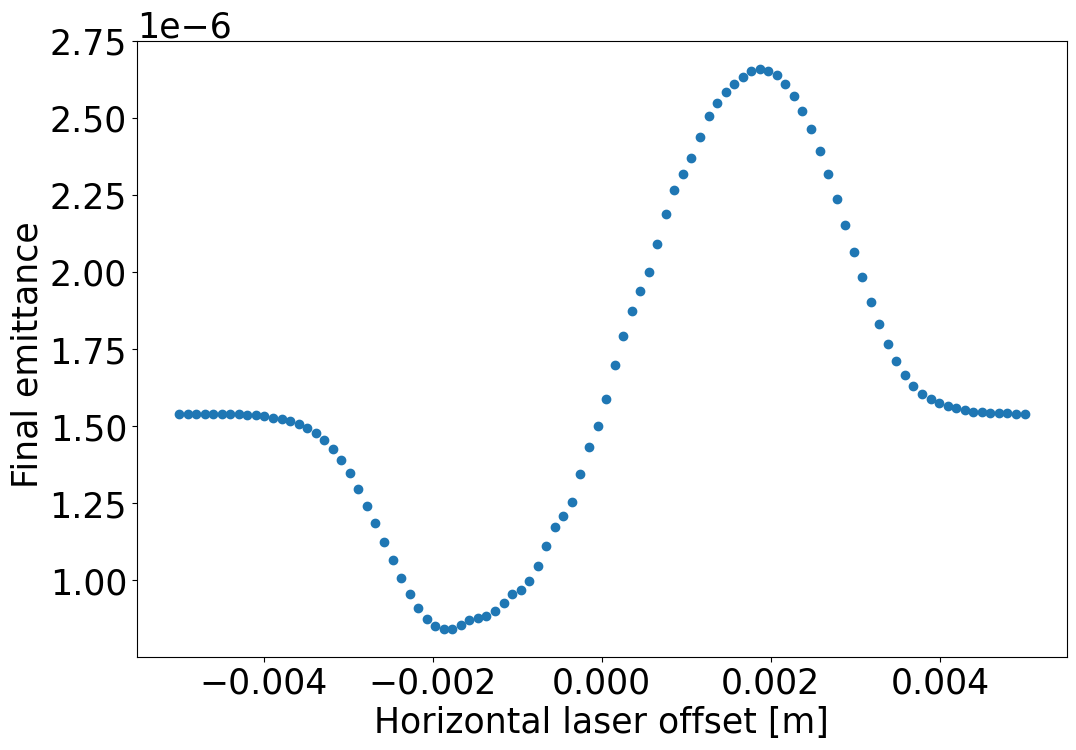

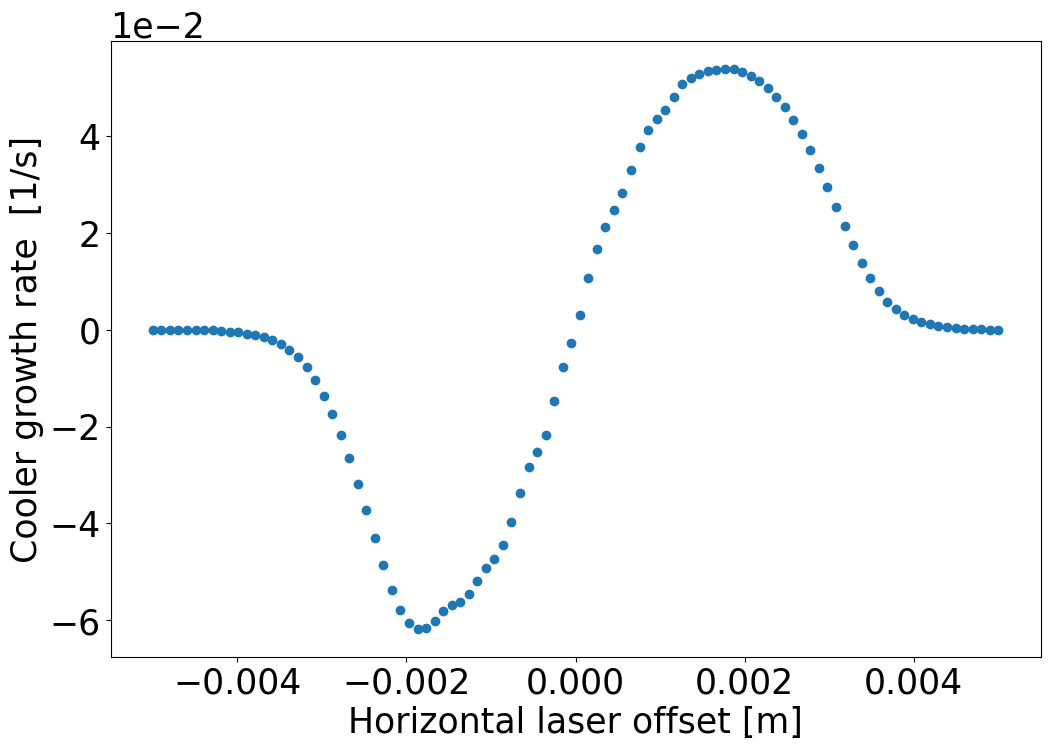

In [56]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.scatter(laser_x_list,final_emittance_list)
plt.xlabel('Horizontal laser offset [m]')
plt.ylabel('Final emittance ')
ax = plt.gca()
# Removing the offset from the y-axis tick labels
ax.yaxis.get_major_formatter().set_useOffset(False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.scatter(laser_x_list,cooler_growth_rates_list)
plt.xlabel('Horizontal laser offset [m]')
plt.ylabel('Cooler growth rate  [1/s]')
ax = plt.gca()
# Removing the offset from the y-axis tick labels
ax.yaxis.get_major_formatter().set_useOffset(False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()